In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import cv2

from sklearn.model_selection import train_test_split

from torch import nn, cuda
from torch.utils import data
from sklearn import metrics
#from transformers import ViTFeatureExtractor, ViTModel, AdamW
from tqdm.auto import tqdm

import splitfolders
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

import random

2023-04-26 13:52:26.199346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#following code uses splitfolder method to organize images and labels for train/val/test

device = torch.device("cuda" if cuda.is_available() else "cpu")
splitfolders.ratio(
    input="./Desktop/COVID-19_Radiography_Dataset/splitfolder", #splitfolder includes only raw images separated by class folders
    output="covid_radiography",
    seed=42,
    ratio=(0.6, 0.3, 0.1),
)


In [3]:
def loadFiles(path):
  #function for loading images as np_arrays to train/val/test sets
  trainImages = []
  for r, d, f in os.walk(path):
    for file in f:
       filepath = os.path.join(r, file)
       img = cv2.imread(filepath) #cv2.IMREAD_GRAYSCALE)

       # Resizing image to size (28, 28)
       img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)

       trainImages.append(img)

    trainImagesNumpy = np.array(np.array(trainImages))
    return trainImagesNumpy

In [6]:
#used only covid images as subsample of data for testing code
x_train = loadFiles('/Users/isifilipovic/covid_radiography/train/images_cov')
x_train.shape

(2169, 32, 32, 3)

In [5]:
x_valid = loadFiles('/Users/isifilipovic/covid_radiography/val/images_cov')
x_valid.shape

(1084, 32, 32, 3)

In [7]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
INPUT_SHAPE = (32, 32, 3)
AUTO = tf.data.AUTOTUNE

#(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar100.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_valid)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(x_valid)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 2169
Testing samples: 1084


In [8]:
IMAGE_SIZE = 48  
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

In [9]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [10]:
#This layer takes images as input and divides them into patches.class Patches(L.Layer):
class Patches(L.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = L.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.suptitle('Original Image')
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        plt.suptitle('Patches')
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 3.


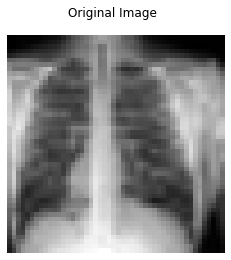

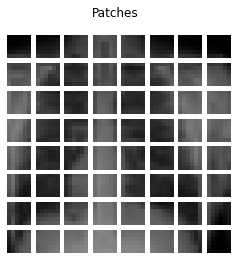

In [26]:
image_batch = next(iter(train_ds))

augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

patch_layer = Patches()
patches = patch_layer(images=augmented_images) #patches = patch_layer(images=image_batch)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches) #random_index = patch_layer.show_patched_image(images=image_batch, patches=patches) 

In [27]:
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2 
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
] 
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [28]:
EPOCHS = 250
DOWNSTREAM_EPOCHS = 250

In [29]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [30]:
class PatchEncoder(L.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = L.Dense(units=self.projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        ) 
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            ) 
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [31]:
def dense_projection(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [32]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = L.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [33]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = L.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    x = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = L.Flatten()(x)
    pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = L.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [34]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [36]:
class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [37]:
test_images = next(iter(valid_ds))


train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)


mae_model.compile(
    optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)


9/9 [==============================] - ETA: 0s - loss: 0.0615 - mae: 0.1946
Idx chosen: 68


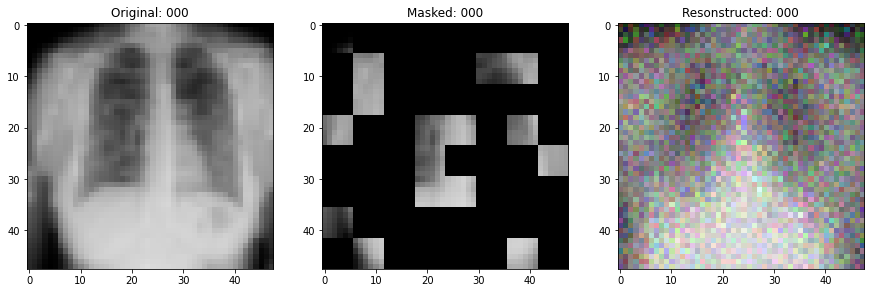

5/5 [==============================] - 6s 1s/step - loss: 0.0451 - mae: 0.1649
Loss: 0.05
MAE: 0.16


In [38]:
#run training with validation loss and mae reported
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

history = mae_model.fit(
    train_ds, epochs=1, validation_data=valid_ds, callbacks=[TrainMonitor(epoch_interval=5), es, rlp],
)

loss, mae = mae_model.evaluate(valid_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")


In [42]:
#Save Model and Weights

# serialize model to JSON
model_json = mae_model.to_json()
with open("/Users/isifilipovic/Desktop/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
mae_model.save_weights("/Users/isifilipovic/Desktop/model.h5")
print("Saved model to disk")

Saved model to disk
